Bagian 1, luas: 2.1432
Bagian 2, luas: 2.1420
Bagian 3, luas: 2.1432
Bagian 4, luas: 2.1429
Bagian 5, luas: 2.1423
Bagian 6, luas: 2.1427
Bagian 7, luas: 2.1437


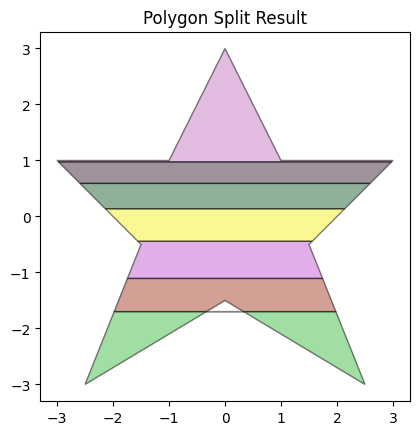

In [ ]:
import matplotlib.pyplot as plt
import random

def shoelace_area(points):
    area = 0.0
    n = len(points)
    for i in range(n):
        x1, y1 = points[i]
        x2, y2 = points[(i + 1) % n]
        area += x1 * y2 - x2 * y1
    return abs(area) / 2

def interpolate_point(p1, p2, t):
    return (p1[0] + t * (p2[0] - p1[0]), p1[1] + t * (p2[1] - p1[1]))

def cut_polygon(polygon, i, j, ti, tj):
    n = len(polygon)
    pi = interpolate_point(polygon[i], polygon[(i + 1) % n], ti)
    pj = interpolate_point(polygon[j], polygon[(j + 1) % n], tj)

    poly1 = [pi]
    k = (i + 1) % n
    while k != (j + 1) % n:
        poly1.append(polygon[k])
        k = (k + 1) % n
    poly1.append(pj)

    poly2 = [pj]
    k = (j + 1) % n
    while k != (i + 1) % n:
        poly2.append(polygon[k])
        k = (k + 1) % n
    poly2.append(pi)

    return poly1, poly2

def find_best_cut(polygon, target_area, steps=10):
    n = len(polygon)
    best = None
    min_len = float('inf')

    for i in range(n):
        for j in range(n):
            if abs(i - j) < 2 or abs(i - j) > n - 2:
                continue
            for si in range(1, steps):
                for sj in range(1, steps):
                    ti, tj = si / steps, sj / steps
                    poly1, poly2 = cut_polygon(polygon, i, j, ti, tj)
                    a1 = shoelace_area(poly1)
                    if abs(a1 - target_area) < 1e-2:
                        # hitung panjang potong
                        pi = interpolate_point(polygon[i], polygon[(i + 1) % n], ti)
                        pj = interpolate_point(polygon[j], polygon[(j + 1) % n], tj)
                        length = ((pi[0] - pj[0]) ** 2 + (pi[1] - pj[1]) ** 2) ** 0.5
                        if length < min_len:
                            min_len = length
                            best = (poly1, poly2)
    return best

def split_polygon(polygon, N):
    result = []
    current = polygon[:]
    for k in range(N - 1):
        area_total = shoelace_area(current)
        target = area_total / (N - k)
        best = find_best_cut(current, target)
        if not best:
            break
        part, current = best
        result.append(part)
    result.append(current)
    return result

def visualize(polygons):
    fig, ax = plt.subplots()
    for poly in polygons:
        x, y = zip(*poly)
        ax.fill(x, y, color=[random.random() for _ in range(3)], alpha=0.5, edgecolor='black')
    ax.set_aspect('equal')
    plt.axis('off')
    plt.show()

# Poligon bintang dari contoh
star = [
    (0, 3), (1, 1), (3, 1),
    (1.5, -0.5), (2.5, -3),
    (0, -1.5), (-2.5, -3),
    (-1.5, -0.5), (-3, 1),
    (-1, 1)
]

parts = split_polygon(star, 5)
for i, p in enumerate(parts):
    print(f"Part {i+1}: Area = {shoelace_area(p):.4f}")
visualize(parts)
